<a href="https://colab.research.google.com/github/khadijaraza/spisproject/blob/main/plasticcdata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from imblearn.over_sampling import SMOTE

import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis

In [19]:
#mapping target numbers to actual class names for celestial object classification
largeclass_map = {
    90: "Supernova Event", #Ia
    67: "Supernova Event", #Ia - Old
    52: "Supernova Event", #Ia - New
    62: "Supernova Event", #Ib/c
    42: "Supernova Event", # Type 2 Supernova
    95: "Supernova Event", #Superluminous Supernova

    65: "Variable Star", #Red Dwarf Stellar Flare
    16: "Variable Star", #Eclipsing Binary Stars
    53: "Variable Star", #Mira Variables
    92: "Variable Star", #RR Lyrae

    15: "Black Hole Event", #Tidal Disruption Event
    88: "Black Hole Event", #Active Galactic Nuclei
    64: "Black Hole Event", #Kilonova
    6:  "Black Hole Event", #Jk this is actually an Unknown Compact Object
}

In [20]:
#reading csv files
lc_df = pd.read_csv("training_set.csv")
meta_df = pd.read_csv("training_set_metadata.csv")
#print(meta_df.info())

#making a folder storing stitched files
folder = "stitched_lc"
os.makedirs(folder, exist_ok=True)

#extracts all unique object ID's (each one represents a star, supernova, etc)
obj_ids = lc_df["object_id"].unique()

#only extracting rows with the certain object id, sorting by mjd, keeping only detected objects, saving the stitched light curve into the folder
for id in tqdm(obj_ids, desc="stitching objects..."):
  obj_lc = lc_df[lc_df["object_id"] == id].sort_values("mjd")
  obj_lc = obj_lc[obj_lc["detected"] == 1]
  output_file = os.path.join(folder, f"obj_{id}.csv")
  obj_lc.to_csv(output_file, index=False)

meta_df.to_csv("training_set_metadatacopy.csv", index=False)

import subprocess
print(int(subprocess.check_output(['wc', '-l', 'training_set_metadata.csv']).split()[0]))
print(int(subprocess.check_output(['wc', '-l', 'training_set_metadatacopy.csv']).split()[0]))

print("Finished stitching light curves")

stitching objects...: 100%|██████████| 7848/7848 [00:38<00:00, 203.15it/s]


7849
7849
Finished stitching light curves


In [21]:
metacopy_df = pd.read_csv("training_set_metadatacopy.csv")

#print(metacopy_df.columns)
#print(metacopy_df.head())

def getFeatures(file_path):
  df = pd.read_csv(file_path)
  flux = df["flux"].values #taking flux values from csv
  time = df["mjd"].values #taking time values from csv

  peak_flux = np.max(flux)
  peak_time = time[np.argmax(flux)] #time of peak flux

  half_max = peak_flux / 2
  above_half = time[flux >= half_max]
  fwhm = above_half.max() - above_half.min() if len(above_half) > 1 else 0

  flux_diff = np.diff(flux)
  vn_ratio = np.sum((flux_diff)**2) / ((len(flux)-1) * np.var(flux)) if len(flux) > 1 else 0
  excess_var = np.var(flux) - np.mean(df["flux_err"].values**2) if "flux_err" in df else np.var(flux)

  features = {
      #flux info
      "mean_flux": np.mean(flux),
      "std_flux": np.std(flux),
      "amplitude": np.max(flux) - np.min(flux),
      "median_flux": np.median(flux),
      "flux_skew": skew(flux),
      "flux_kurtosis": kurtosis(flux),
      "flux_p25": np.percentile(flux, 25),
      "flux_p75": np.percentile(flux, 75),
      "flux_range_50": np.percentile(flux, 75) - np.percentile(flux, 25),

      # Time-based features
      "lc_duration": time.max() - time.min(),
      "rise_time": time[np.argmax(flux)] - time.min(),
      "decay_time": time.max() - time[np.argmax(flux)],
      "rise_decay_ratio": (peak_time - time.min()) / (time.max() - peak_time + 1e-5),
      "fwhm": fwhm,

      #variability
      "vn_ratio": vn_ratio,
      "excess_var": excess_var,

      #slopes
      "slope_mean": np.mean(np.diff(flux) / np.diff(time)),
      "slope_std": np.std(np.diff(flux) / np.diff(time)),
  }
  return features

feature_list = []
for name in os.listdir(folder): #iterates through lc csv's in the stiched_lc folder
  if name.endswith(".csv"):
        obj_id = int(name.replace(".csv", "").replace("obj_", "")) #object ID is extracted from each file name
        feats = getFeatures(os.path.join(folder, name))
        feats["object_id"] = obj_id
        feature_list.append(feats)

features_df = pd.DataFrame(feature_list)
data = features_df.merge(meta_df[["object_id", "target"]], on="object_id")
data["largeclass"] = data["target"].map(largeclass_map)

                  precision    recall  f1-score   support

Black Hole Event       0.91      0.91      0.91       911
 Supernova Event       0.91      0.92      0.91       911
   Variable Star       0.98      0.97      0.97       912

        accuracy                           0.93      2734
       macro avg       0.93      0.93      0.93      2734
    weighted avg       0.93      0.93      0.93      2734



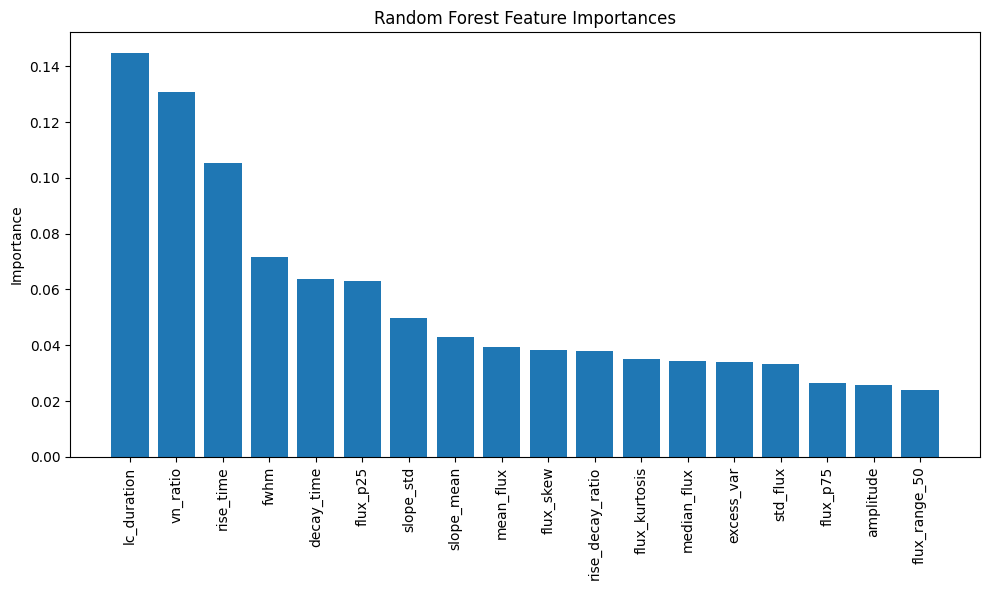

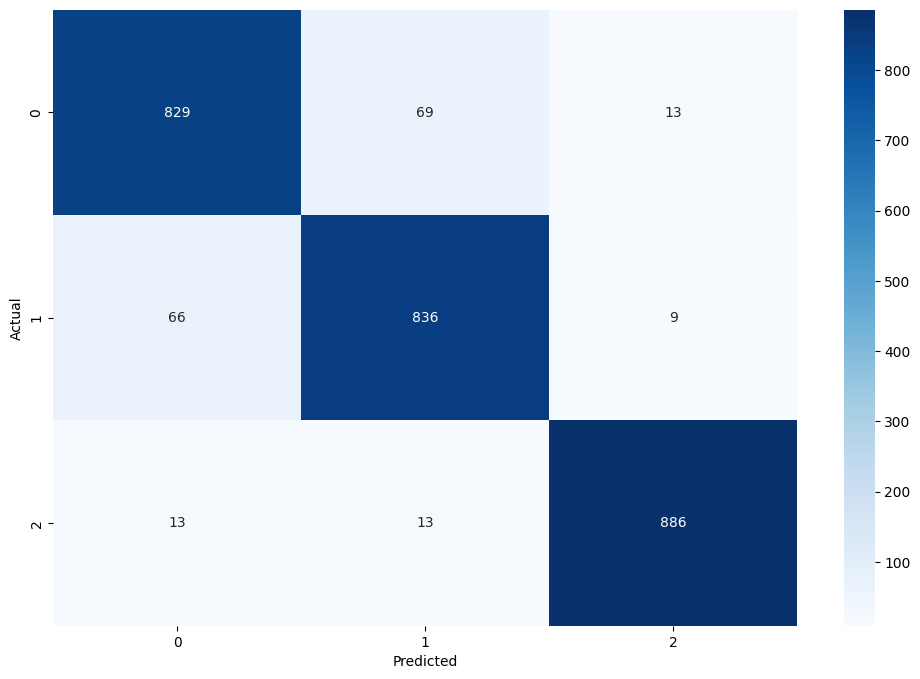

In [22]:
X = data.drop(columns=["object_id", "target", "largeclass"], errors="ignore") #feature columns
y = data["largeclass"] #class labels

#SMOTE will handle the rarer supernovae/classes as minorities are underrepresented in ML models
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, random_state=42, stratify=y_res
)

clf = RandomForestClassifier(
    n_estimators=300,        # number of trees
    class_weight="balanced", # handles rare classes
    random_state=42,         # reproducibility
    n_jobs=-1                # use all CPU cores (faster)
)
clf.fit(X_train, y_train)

#predictions
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

#printing out feature importances
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10,6))
plt.bar(range(X.shape[1]), importances[indices])
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.title("Random Forest Feature Importances")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

#printing out a confusion matrix,
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

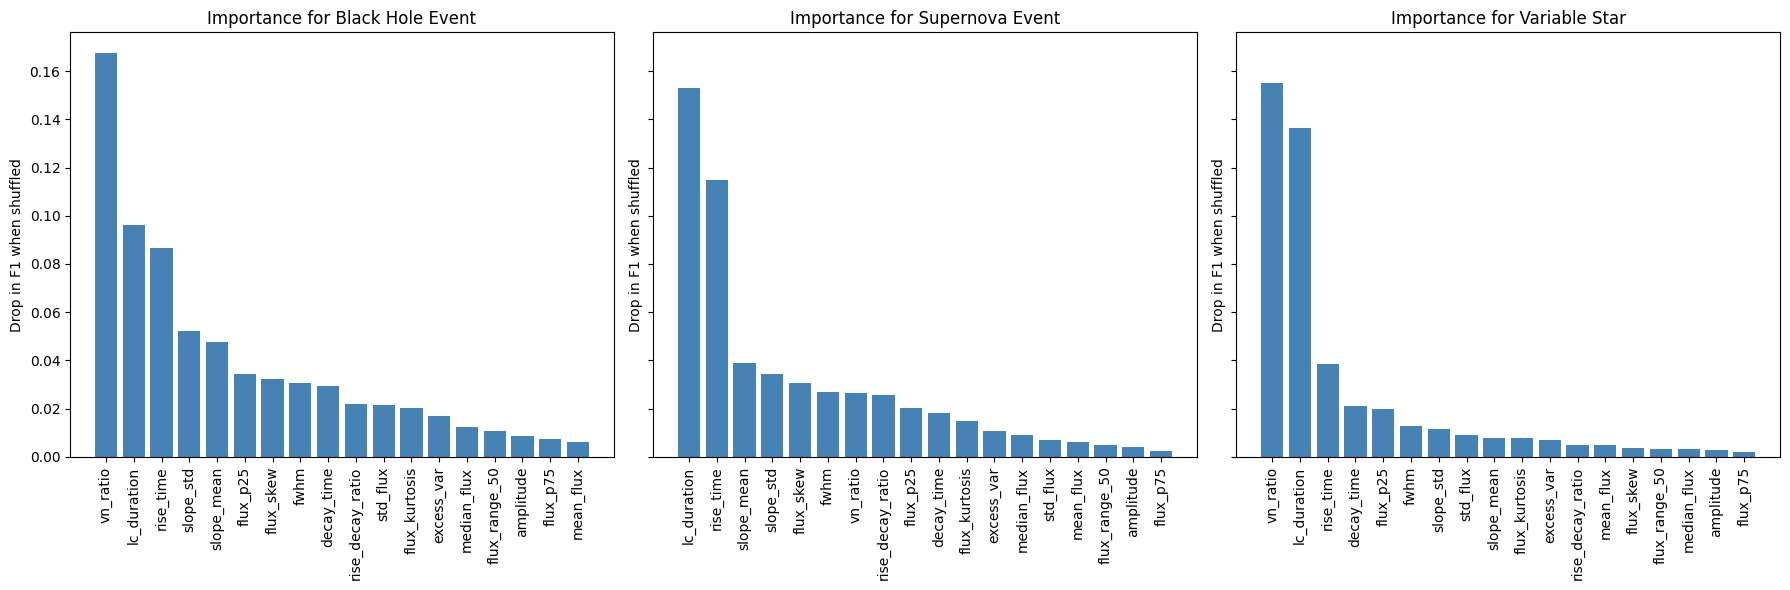

In [23]:
#printing out what features help the model identify a single class, not just overall
def find_class_specific_feat(model, X, y, class_label):
  base_score = f1_score(y == class_label, model.predict(X) == class_label)
  importances = []
  for col in X.columns:
    X_shuffled = X.copy()
    X_shuffled[col] = np.random.permutation(X_shuffled[col].values)
    shuffled_score = f1_score(y == class_label, model.predict(X_shuffled) == class_label)
    importances.append(base_score - shuffled_score)
  return np.array(importances)

# Side-by-side plots
classes = ["Black Hole Event", "Supernova Event", "Variable Star"]

fig, axes = plt.subplots(1, len(classes), figsize=(18, 6), sharey=True)
for i, cls in enumerate(classes):
    cls_importances = find_class_specific_feat(clf, X_test, y_test, class_label=cls)
    indices = np.argsort(cls_importances)[::-1]
    axes[i].bar(range(X.shape[1]), cls_importances[indices], color="steelblue")
    axes[i].set_xticks(range(X.shape[1]))
    axes[i].set_xticklabels(X.columns[indices], rotation=90)
    axes[i].set_title(f"Importance for {cls}")
    axes[i].set_ylabel("Drop in F1 when shuffled")

plt.tight_layout()
plt.show()

In [24]:
# In your training notebook (plasticcdata.ipynb)

import joblib
import pickle

# --- Save the trained Random Forest model ---
model_filename = 'random_forest_model.joblib'
joblib.dump(clf, model_filename)
print(f"Model saved to '{model_filename}'")

# --- Save the list of feature columns ---
# The model needs to see features in the exact same order during prediction.
feature_columns = X.columns.tolist()
features_filename = 'feature_columns.pkl'
with open(features_filename, 'wb') as f:
    pickle.dump(feature_columns, f)
print(f"Feature columns saved to '{features_filename}'")

Model saved to 'random_forest_model.joblib'
Feature columns saved to 'feature_columns.pkl'
